# Finetuning and LLC in Grokking

This notebook explores how repetitive finetuning (sequential training on different unrelated moduli) affects the Local Learning Coefficient (LLC) and grokking behavior in modular arithmetic.

**Based on the devinterp grokking example:**  
https://github.com/timaeus-research/devinterp/blob/main/examples/grokking.ipynb

**Research Question:**  
Does repetitive finetuning produce different LLC trajectories compared to direct training on the hardest task? 

**Key Distinction:**  
Unlike curriculum learning where later tasks contain earlier tasks as special cases, in finetuning the tasks are **unrelated** - each new modulus does not necessarily contain the previous one.

**Setup:**
- **Finetuning:** Train sequentially on mod-7, then mod-11, then mod-23, then mod-49, then mod-53 (unrelated moduli)
- **Direct:** Train directly on mod-53 from scratch
- Track train/test accuracy, loss, and LLC at each stage to see how model complexity evolves

**Hypothesis:**  
Finetuning on different tasks may create different learning dynamics compared to curriculum learning, potentially affecting the model's ability to grokk.

## 1. Import Required Libraries
Import torch, numpy, matplotlib, pandas, tqdm, devinterp, and other required libraries.

In [1]:
# Install required packages if running in a fresh environment
%pip install devinterp nbformat

import random
from copy import deepcopy
from dataclasses import dataclass
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from tqdm import tqdm
from pathlib import Path

from devinterp.optim.sgld import SGLD
from devinterp.slt.sampler import estimate_learning_coeff_with_summary
from devinterp.utils import evaluate_ce

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

# Create results directory for saving figures
RESULTS_DIR = Path("../results/finetuning")
RESULTS_DIR.mkdir(parents=True, exist_ok=True)
print(f"Saving results to: {RESULTS_DIR.absolute()}")

# Utility function to save and show figures
def save_and_show(fig, filename, dpi=300):
    """Save figure to results directory and display it"""
    filepath = RESULTS_DIR / filename
    fig.savefig(filepath, dpi=dpi, bbox_inches='tight')
    print(f"Saved: {filepath.name}")
    plt.show()
    
print("Setup complete!")

/home/dorian/Projects/llc/venv/bin/python: No module named pip
Note: you may need to restart the kernel to use updated packages.
Saving results to: /home/dorian/Projects/llc/main_experiment/../results/finetuning
Setup complete!


In [2]:
# Set all seeds for reproducibility
SEED = 0
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed(SEED)
    torch.cuda.manual_seed_all(SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

## 2. Define Experiment Parameters for Finetuning and Direct Training
Set up dataclasses or dictionaries for experiment parameters, including moduli for finetuning sequence, training hyperparameters, and random seeds.

In [3]:
@dataclass
class ExperimentParams:
    n_batches: int = 50000
    n_save_model_checkpoints: int = 100
    print_times: int = 100  # Matches n_save_model_checkpoints for aligned plotting
    lr: float = 0.005
    batch_size: int = 128
    hidden_size: int = 48
    embed_dim: int = 12
    train_frac: float = 0.4
    random_seed: int = 0
    device: str = DEVICE
    weight_decay: float = 0.0002

# Finetuning sequence: unrelated moduli (not powers of 2, not subsets of each other)
FINETUNING_MODULI = [7, 21, 33, 49, 53]
DIRECT_MODULUS = FINETUNING_MODULI[-1]

## 3. Define MLP Model and Utility Functions
Implement the MLP model class, test, train, and dataset utility functions as in the original grokking notebook.

In [4]:
class MLP(nn.Module):
    def __init__(self, params):
        super().__init__()
        self.embedding = nn.Embedding(params.p, params.embed_dim)
        self.linear1r = nn.Linear(params.embed_dim, params.hidden_size, bias=True)
        self.linear1l = nn.Linear(params.embed_dim, params.hidden_size, bias=True)
        self.linear2 = nn.Linear(params.hidden_size, params.p, bias=False)
        self.act = nn.GELU()
        self.vocab_size = params.p

    def forward(self, x):
        x = x.to(self.embedding.weight.device)  # Ensure input is on same device as embedding
        x1 = self.embedding(x[..., 0])
        x2 = self.embedding(x[..., 1])
        x1 = self.linear1l(x1)
        x2 = self.linear1r(x2)
        x = x1 + x2
        x = self.act(x)
        x = self.linear2(x)
        return x

def test(model, dataset, device):
    n_correct = 0
    total_loss = 0
    model.eval()
    loss_fn = nn.CrossEntropyLoss()
    with torch.no_grad():
        for x, y in dataset:
            x, y = x.to(device), y.to(device)
            out = model(x)
            loss = loss_fn(out, y)
            total_loss += loss.item()
            pred = torch.argmax(out)
            if pred == y:
                n_correct += 1
    return n_correct / len(dataset), total_loss / len(dataset)

def train(train_dataset, test_dataset, params, model=None, verbose=True):
    all_models = []
    if model is None:
        model = MLP(params).to(params.device)
    optimizer = torch.optim.Adam(
        model.parameters(), weight_decay=params.weight_decay, lr=params.lr
    )
    loss_fn = torch.nn.CrossEntropyLoss()
    train_loader = DataLoader(train_dataset, batch_size=params.batch_size, shuffle=True)
    print_every = params.n_batches // params.print_times
    checkpoint_every = None
    if params.n_save_model_checkpoints > 0:
        checkpoint_every = params.n_batches // params.n_save_model_checkpoints
    loss_data = []
    if verbose:
        pbar = tqdm(total=params.n_batches, desc="Training")
    for i in range(params.n_batches):
        batch = next(iter(train_loader))
        X, Y = batch
        X, Y = X.to(params.device), Y.to(params.device)
        optimizer.zero_grad()
        out = model(X)
        loss = loss_fn(out, Y)
        loss.backward()
        optimizer.step()
        if checkpoint_every and (i + 1) % checkpoint_every == 0:
            all_models += [deepcopy(model)]
        if (i + 1) % print_every == 0:
            val_acc, val_loss = test(model, test_dataset, params.device)
            train_acc, train_loss = test(model, train_dataset, params.device)
            loss_data.append(
                {
                    "batch": i + 1,
                    "train_loss": train_loss,
                    "train_acc": train_acc,
                    "val_loss": val_loss,
                    "val_acc": val_acc,
                }
            )
            if verbose:
                pbar.set_postfix(
                    {
                        "train_loss": f"{train_loss:.4f}",
                        "train_acc": f"{train_acc:.4f}",
                        "val_loss": f"{val_loss:.4f}",
                        "val_acc": f"{val_acc:.4f}",
                    }
                )
                pbar.update(print_every)
    if verbose:
        pbar.close()
    df = pd.DataFrame(loss_data)
    train_acc, train_loss = test(model, train_dataset, params.device)
    val_acc, val_loss = test(model, test_dataset, params.device)
    if verbose:
        print(f"Final Train Acc: {train_acc:.4f} | Final Train Loss: {train_loss:.4f}")
        print(f"Final Val Acc: {val_acc:.4f} | Final Val Loss: {val_loss:.4f}")
    return all_models, df

def deterministic_shuffle(lst, seed):
    random.seed(seed)
    random.shuffle(lst)
    return lst

def get_all_pairs(p):
    pairs = []
    for i in range(p):
        for j in range(p):
            pairs.append((i, j))
    return set(pairs)

def make_dataset(p):
    data = []
    pairs = get_all_pairs(p)
    for a, b in pairs:
        data.append((torch.tensor([a, b]), torch.tensor((a + b) % p)))
    return data

def train_test_split(dataset, train_split_proportion, seed):
    l = len(dataset)
    train_len = int(train_split_proportion * l)
    idx = list(range(l))
    idx = deterministic_shuffle(idx, seed)
    train_idx = idx[:train_len]
    test_idx = idx[train_len:]
    return [dataset[i] for i in train_idx], [dataset[i] for i in test_idx]

## 4. Create Modular Addition Datasets for Each Modulus
Generate datasets for each modulus in the finetuning sequence (7, 11, 23, 49, 53) and for direct training (53).

In [5]:
# Prepare datasets for each modulus in finetuning sequence and for direct training
finetuning_datasets = {}
finetuning_splits = {}
for p in FINETUNING_MODULI:
    dataset = make_dataset(p)
    train_data, test_data = train_test_split(dataset, 0.4, 0)  # Use same split for all
    finetuning_datasets[p] = dataset
    finetuning_splits[p] = (train_data, test_data)

direct_dataset = make_dataset(DIRECT_MODULUS)
direct_train_data, direct_test_data = train_test_split(direct_dataset, 0.4, 0)

## 5. Finetuning Training Loop
Iteratively train the model on each modulus in the finetuning sequence, transferring weights to the next stage. Note: unlike curriculum learning, these moduli are unrelated to each other.

In [6]:
finetuning_checkpoints = []
finetuning_dfs = []
prev_model = None

for i, p in enumerate(FINETUNING_MODULI):
    print(f"\nFinetuning on mod-{p} (stage {i+1}/{len(FINETUNING_MODULI)})")
    params = ExperimentParams()
    params.p = p
    params.device = DEVICE  # Ensure device is set
    train_data, test_data = finetuning_splits[p]
    
    # If not first stage, transfer weights (resize embedding/output layers if needed)
    if prev_model is not None:
        model = MLP(params)
        # Transfer weights for layers that match in shape
        model_dict = model.state_dict()
        prev_dict = prev_model.state_dict()
        for k in model_dict:
            if k in prev_dict and model_dict[k].shape == prev_dict[k].shape:
                model_dict[k] = prev_dict[k]
        model.load_state_dict(model_dict)
        model = model.to(params.device)  # Ensure model is on correct device
    else:
        model = None
    
    # Move all data to correct device
    train_data = [(x.to(params.device), y.to(params.device)) for x, y in train_data]
    test_data = [(x.to(params.device), y.to(params.device)) for x, y in test_data]
    
    checkpoints, df = train(train_data, test_data, params, model=model, verbose=True)
    finetuning_checkpoints.append(checkpoints)
    finetuning_dfs.append(df)
    prev_model = checkpoints[-1]


Finetuning on mod-7 (stage 1/5)


Training: 100%|██████████| 50000/50000 [00:33<00:00, 1486.34it/s, train_loss=0.0009, train_acc=1.0000, val_loss=9.1848, val_acc=0.0000]


Final Train Acc: 1.0000 | Final Train Loss: 0.0009
Final Val Acc: 0.0000 | Final Val Loss: 9.1848

Finetuning on mod-21 (stage 2/5)


Training: 100%|██████████| 50000/50000 [00:46<00:00, 1071.09it/s, train_loss=0.0045, train_acc=1.0000, val_loss=1.6187, val_acc=0.5509]


Final Train Acc: 1.0000 | Final Train Loss: 0.0045
Final Val Acc: 0.5509 | Final Val Loss: 1.6187

Finetuning on mod-33 (stage 3/5)


Training: 100%|██████████| 50000/50000 [01:07<00:00, 738.58it/s, train_loss=0.0078, train_acc=1.0000, val_loss=0.2059, val_acc=0.9557]


Final Train Acc: 1.0000 | Final Train Loss: 0.0078
Final Val Acc: 0.9557 | Final Val Loss: 0.2059

Finetuning on mod-49 (stage 4/5)


Training: 100%|██████████| 50000/50000 [01:50<00:00, 453.89it/s, train_loss=0.0112, train_acc=1.0000, val_loss=0.0458, val_acc=1.0000] 


Final Train Acc: 1.0000 | Final Train Loss: 0.0112
Final Val Acc: 1.0000 | Final Val Loss: 0.0458

Finetuning on mod-53 (stage 5/5)


Training: 100%|██████████| 50000/50000 [01:57<00:00, 426.28it/s, train_loss=0.0121, train_acc=1.0000, val_loss=0.0448, val_acc=1.0000]


Final Train Acc: 1.0000 | Final Train Loss: 0.0121
Final Val Acc: 1.0000 | Final Val Loss: 0.0448


## 6. Direct Training Loop
Train a separate model directly on mod-53, saving checkpoints as in the finetuning approach.

In [7]:
print("\nDirect training")
direct_params = ExperimentParams()
direct_params.p = DIRECT_MODULUS
direct_checkpoints, direct_df = train(direct_train_data, direct_test_data, direct_params, model=None, verbose=True)


Direct training


Training: 100%|██████████| 50000/50000 [03:12<00:00, 259.92it/s, train_loss=0.0134, train_acc=1.0000, val_loss=0.0872, val_acc=0.9935] 


Final Train Acc: 1.0000 | Final Train Loss: 0.0134
Final Val Acc: 0.9935 | Final Val Loss: 0.0872


## 7. Plot Accuracy and Loss for Finetuning and Direct Training
Plot train/test accuracy and loss curves for both finetuning and direct training approaches.

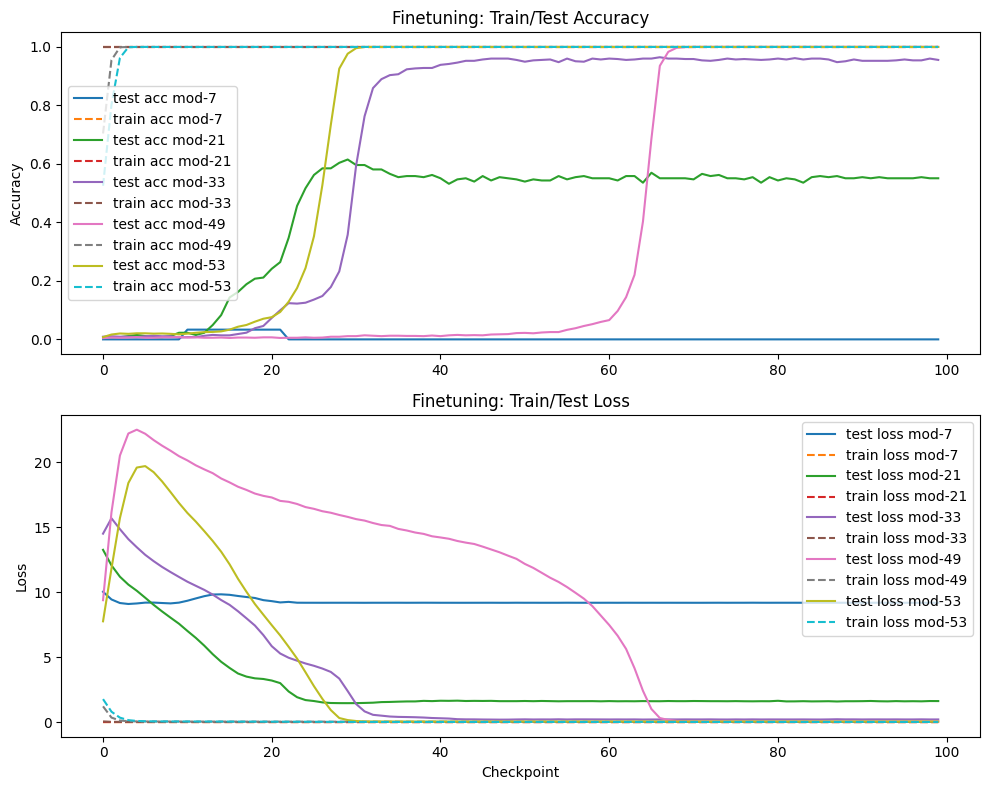

Saved: finetuning_train_test_accuracy_loss.png


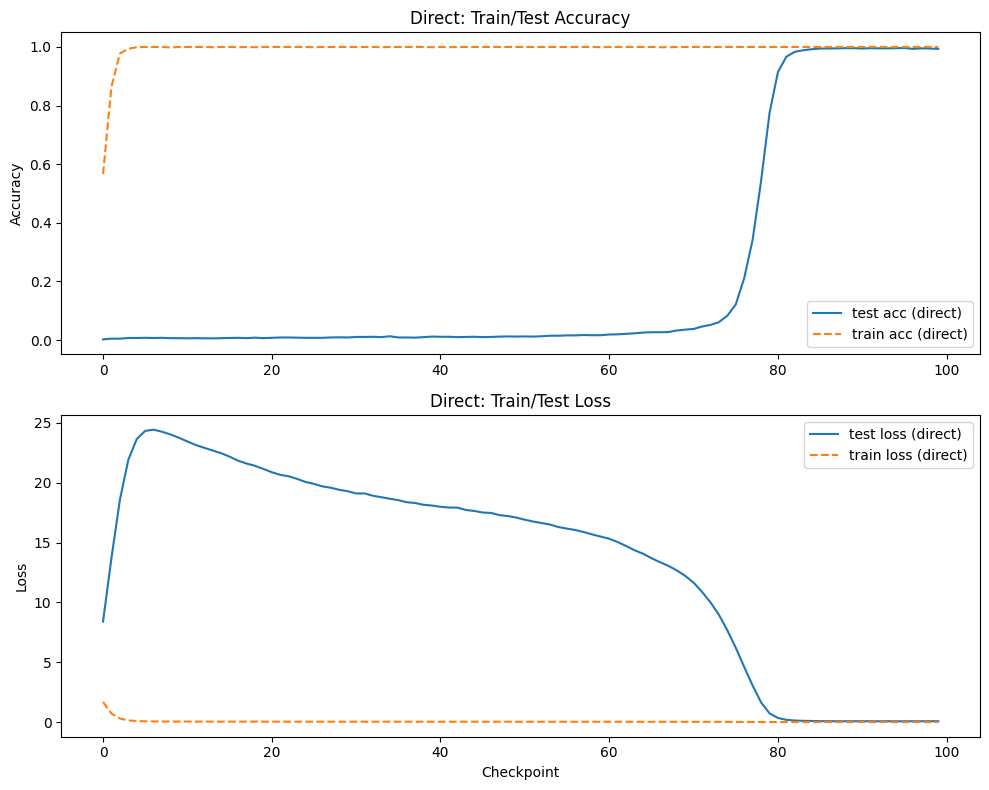

Saved: direct_train_test_accuracy_loss.png


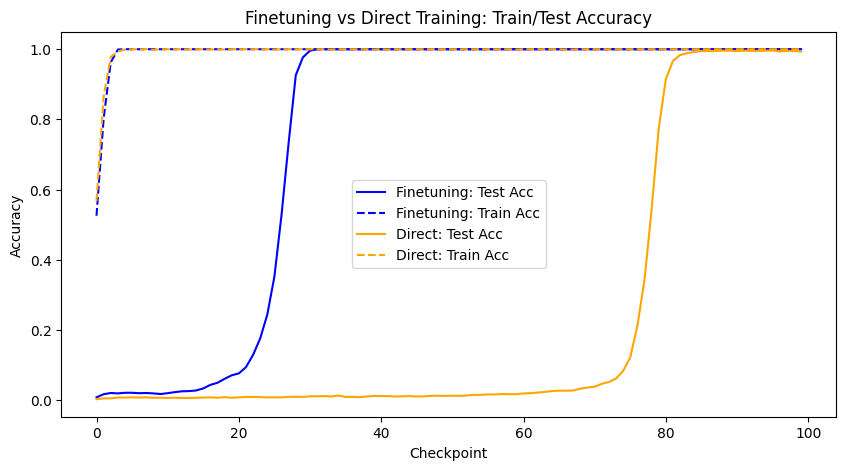

Saved: finetuning_vs_direct_accuracy.png


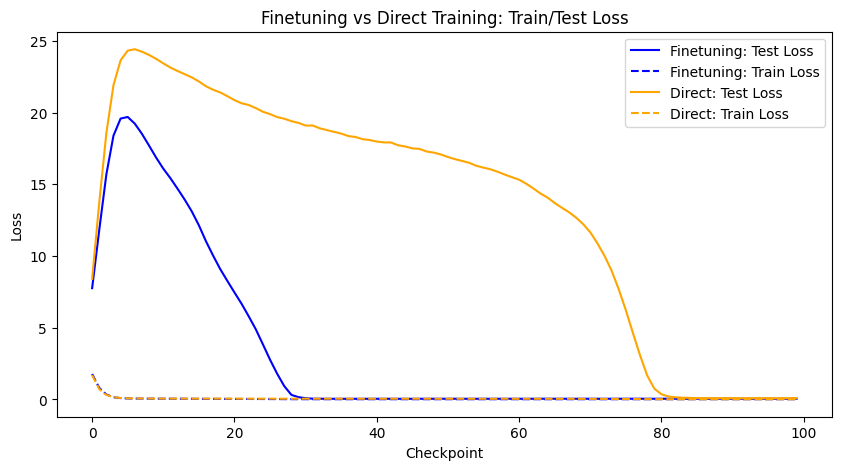

Saved: finetuning_vs_direct_loss.png


In [8]:
# Plot finetuning accuracy/loss
fig, axs = plt.subplots(2, 1, figsize=(10, 8))
for i, (df, p) in enumerate(zip(finetuning_dfs, FINETUNING_MODULI)):
    axs[0].plot(df["val_acc"], label=f"test acc mod-{p}")
    axs[0].plot(df["train_acc"], label=f"train acc mod-{p}", linestyle='--')
    axs[1].plot(df["val_loss"], label=f"test loss mod-{p}")
    axs[1].plot(df["train_loss"], label=f"train loss mod-{p}", linestyle='--')
axs[0].set_ylabel("Accuracy")
axs[1].set_ylabel("Loss")
axs[1].set_xlabel("Checkpoint")
axs[0].legend()
axs[1].legend()
axs[0].set_title("Finetuning: Train/Test Accuracy")
axs[1].set_title("Finetuning: Train/Test Loss")
plt.tight_layout()
plt.show()
save_and_show(fig, "finetuning_train_test_accuracy_loss.png")


# Plot direct accuracy/loss
fig, axs = plt.subplots(2, 1, figsize=(10, 8))
axs[0].plot(direct_df["val_acc"], label="test acc (direct)")
axs[0].plot(direct_df["train_acc"], label="train acc (direct)", linestyle='--')
axs[1].plot(direct_df["val_loss"], label="test loss (direct)")
axs[1].plot(direct_df["train_loss"], label="train loss (direct)", linestyle='--')
axs[0].set_ylabel("Accuracy")
axs[1].set_ylabel("Loss")
axs[1].set_xlabel("Checkpoint")
axs[0].legend()
axs[1].legend()
axs[0].set_title("Direct: Train/Test Accuracy")
axs[1].set_title("Direct: Train/Test Loss")
plt.tight_layout()
plt.show()
save_and_show(fig, "direct_train_test_accuracy_loss.png")

# Plot final finetuning stage vs direct training accuracy comparison
finetuning_final = finetuning_dfs[-1]
fig = plt.figure(figsize=(10, 5))
plt.plot(finetuning_final["val_acc"], label="Finetuning: Test Acc", color='blue')
plt.plot(finetuning_final["train_acc"], label="Finetuning: Train Acc", color='blue', linestyle='--')
plt.plot(direct_df["val_acc"], label="Direct: Test Acc", color='orange')
plt.plot(direct_df["train_acc"], label="Direct: Train Acc", color='orange', linestyle='--')
plt.xlabel("Checkpoint")
plt.ylabel("Accuracy")
plt.title("Finetuning vs Direct Training: Train/Test Accuracy")
plt.legend()
plt.show()
save_and_show(fig, "finetuning_vs_direct_accuracy.png")

# Plot final finetuning stage vs direct training loss comparison
fig = plt.figure(figsize=(10, 5))
plt.plot(finetuning_final["val_loss"], label="Finetuning: Test Loss", color='blue')
plt.plot(finetuning_final["train_loss"], label="Finetuning: Train Loss", color='blue', linestyle='--')
plt.plot(direct_df["val_loss"], label="Direct: Test Loss", color='orange')
plt.plot(direct_df["train_loss"], label="Direct: Train Loss", color='orange', linestyle='--')
plt.xlabel("Checkpoint")
plt.ylabel("Loss")
plt.title("Finetuning vs Direct Training: Train/Test Loss")
plt.legend()
plt.show()
save_and_show(fig, "finetuning_vs_direct_loss.png")

## 7.5 Verify Loss Trace Convergence (LLC Hyperparameter Test)

Before estimating LLC on all checkpoints, verify that the loss trace converges properly with the chosen hyperparameters. This follows the devinterp example pattern.

In [9]:
# LLC hyperparameters (from devinterp example)
lr = 3e-3  # epsilon
nbeta = 2.0
gamma = 5.0  # localization
num_chains = 1  # Use 1 chain for individual checkpoint estimation

# Test on final finetuning checkpoint with more draws to verify convergence
print(f"Testing LLC estimation on final finetuning checkpoint (mod-{FINETUNING_MODULI[-1]})...")
final_params = ExperimentParams()
final_params.p = FINETUNING_MODULI[-1]
train_data, _ = finetuning_splits[FINETUNING_MODULI[-1]]
loader = DataLoader(train_data, batch_size=final_params.batch_size, shuffle=True)

test_llc_stats = estimate_learning_coeff_with_summary(
    finetuning_checkpoints[-1][-1],  # Last checkpoint of last stage
    loader=loader,
    evaluate=evaluate_ce,
    sampling_method=SGLD,
    optimizer_kwargs=dict(lr=lr, nbeta=nbeta, localization=gamma),
    num_chains=3,  # Use more chains for verification
    num_draws=1500,  # Use more draws to check convergence
    device=DEVICE,
    online=True,  # Use online=True to get loss/trace for visualization
)
print(f"Keys returned: {test_llc_stats.keys()}")

Testing LLC estimation on final finetuning checkpoint (mod-53)...


/home/dorian/Projects/llc/venv/lib/python3.12/site-packages/devinterp/slt/sampler.py:117: UserWarning: Using passed in nbeta. Make sure callbacks are also initialized with the same nbeta.
  warnings.warn(
/home/dorian/Projects/llc/venv/lib/python3.12/site-packages/devinterp/backends/default/slt/sampler.py:240: UserWarning: You are taking more draws than burn-in steps, your LLC estimates will likely be underestimates. Please check LLC chain convergence.
  warnings.warn(
/home/dorian/Projects/llc/venv/lib/python3.12/site-packages/devinterp/backends/default/slt/sampler.py:244: UserWarning: You are taking more sample batches than there are dataloader batches available, this removes some randomness from sampling but is probably fine. (All sample batches beyond the number dataloader batches are cycled from the start, f.e. 9 samples from [A, B, C] would be [B, A, C, B, A, C, B, A, C].)
  warnings.warn(
/home/dorian/Projects/llc/venv/lib/python3.12/site-packages/devinterp/backends/default/slt/

Keys returned: dict_keys(['init_loss', 'llc/means', 'llc/stds', 'llc/trace', 'loss/trace'])


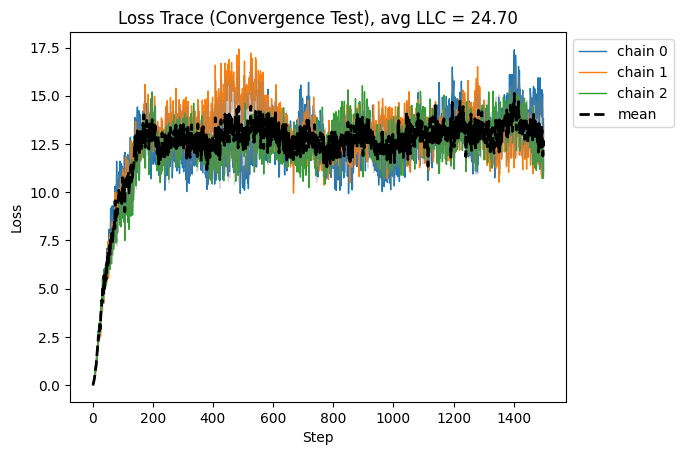

<Figure size 1200x600 with 0 Axes>


Average LLC from 1500 chains: 24.70
If the loss trace flattens out, the hyperparameters are good for LLC estimation.


In [10]:
# Plot loss trace to verify convergence
from devinterp.utils import plot_trace

trace = test_llc_stats["loss/trace"]
avg_llc = sum(test_llc_stats['llc/means']) / len(test_llc_stats['llc/means'])

plot_trace(
    trace,
    "Loss",
    x_axis="Step",
    title=f"Loss Trace (Convergence Test), avg LLC = {avg_llc:.2f}",
    plot_mean=False,
    plot_std=False,
    fig_size=(12, 6),
    true_lc=None,
)
print(f"\nAverage LLC from {len(test_llc_stats['llc/means'])} chains: {avg_llc:.2f}")
print("If the loss trace flattens out, the hyperparameters are good for LLC estimation.")

## 8. Estimate LLC for All Finetuning Checkpoints

Estimate the Local Learning Coefficient (LLC) for every checkpoint across all finetuning stages using the devinterp SGLD-based estimator. This will show how model complexity evolves during sequential finetuning on unrelated tasks.

In [11]:
num_draws = 1000

# Estimate LLC for ALL checkpoints in each finetuning stage
# Note: Use online=False to get 'llc/mean' (single value) instead of 'llc/means' (array per chain)
print("\n" + "="*80)
print("Estimating LLC for all finetuning checkpoints...")
print("="*80)

finetuning_llcs_by_stage = []

for stage_idx, (checkpoints, p) in enumerate(zip(finetuning_checkpoints, FINETUNING_MODULI)):
    print(f"\nStage {stage_idx+1}/{len(FINETUNING_MODULI)}: mod-{p}")
    print(f"  Estimating LLC for {len(checkpoints)} checkpoints...")
    
    params = ExperimentParams()
    params.p = p
    train_data, _ = finetuning_splits[p]
    loader = DataLoader(train_data, batch_size=params.batch_size, shuffle=True)
    
    stage_llcs = []
    for checkpoint_idx, model_checkpoint in enumerate(checkpoints):
        if (checkpoint_idx + 1) % 20 == 0 or checkpoint_idx == 0 or checkpoint_idx == len(checkpoints) - 1:
            print(f"    Checkpoint {checkpoint_idx+1}/{len(checkpoints)}")
        
        llc_stats = estimate_learning_coeff_with_summary(
            model_checkpoint,
            loader=loader,
            evaluate=evaluate_ce,
            sampling_method=SGLD,
            optimizer_kwargs=dict(lr=lr, nbeta=nbeta, localization=gamma),
            num_chains=num_chains,
            num_draws=num_draws,
            device=DEVICE,
            online=False,  # Use online=False to get 'llc/mean' instead of 'llc/means'
        )
        stage_llcs.append(llc_stats)
    
    finetuning_llcs_by_stage.append(stage_llcs)
    print(f"  Completed mod-{p}: LLC range [{min(llc['llc/mean'] for llc in stage_llcs):.2f}, {max(llc['llc/mean'] for llc in stage_llcs):.2f}]")

print("\n" + "="*80)
print("Finetuning LLC estimation complete!")
print("="*80)


Estimating LLC for all finetuning checkpoints...

Stage 1/5: mod-7
  Estimating LLC for 100 checkpoints...
    Checkpoint 1/100


Chain 0: 100%|██████████| 1000/1000 [00:01<00:00, 864.25it/s]
/home/dorian/Projects/llc/venv/lib/python3.12/site-packages/devinterp/slt/llc.py:109: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at /pytorch/aten/src/ATen/native/ReduceOps.cpp:1857.)
  self.llc_std = self.llc_per_chain.std()
Chain 0: 100%|██████████| 1000/1000 [00:01<00:00, 814.75it/s]


    Checkpoint 20/100


Chain 0: 100%|██████████| 1000/1000 [00:01<00:00, 855.77it/s]


    Checkpoint 40/100


Chain 0: 100%|██████████| 1000/1000 [00:01<00:00, 903.71it/s]


    Checkpoint 60/100


Chain 0: 100%|██████████| 1000/1000 [00:01<00:00, 886.77it/s]


    Checkpoint 80/100


Chain 0: 100%|██████████| 1000/1000 [00:01<00:00, 789.87it/s]


    Checkpoint 100/100


Chain 0: 100%|██████████| 1000/1000 [00:01<00:00, 892.27it/s]


  Completed mod-7: LLC range [3.11, 6.05]

Stage 2/5: mod-21
  Estimating LLC for 100 checkpoints...
    Checkpoint 1/100


Chain 0: 100%|██████████| 1000/1000 [00:01<00:00, 868.51it/s]


    Checkpoint 20/100


Chain 0: 100%|██████████| 1000/1000 [00:01<00:00, 870.84it/s]


    Checkpoint 40/100


Chain 0: 100%|██████████| 1000/1000 [00:01<00:00, 878.24it/s]


    Checkpoint 60/100


Chain 0: 100%|██████████| 1000/1000 [00:01<00:00, 872.77it/s]


    Checkpoint 80/100


Chain 0: 100%|██████████| 1000/1000 [00:01<00:00, 898.40it/s]


    Checkpoint 100/100


Chain 0: 100%|██████████| 1000/1000 [00:01<00:00, 921.79it/s]


  Completed mod-21: LLC range [14.37, 24.09]

Stage 3/5: mod-33
  Estimating LLC for 100 checkpoints...
    Checkpoint 1/100


Chain 0: 100%|██████████| 1000/1000 [00:01<00:00, 861.70it/s]


    Checkpoint 20/100


Chain 0: 100%|██████████| 1000/1000 [00:01<00:00, 844.53it/s]


    Checkpoint 40/100


Chain 0: 100%|██████████| 1000/1000 [00:01<00:00, 841.54it/s]


    Checkpoint 60/100


Chain 0: 100%|██████████| 1000/1000 [00:01<00:00, 807.96it/s]


    Checkpoint 80/100


Chain 0: 100%|██████████| 1000/1000 [00:01<00:00, 861.51it/s]


    Checkpoint 100/100


Chain 0: 100%|██████████| 1000/1000 [00:01<00:00, 789.25it/s]


  Completed mod-33: LLC range [18.68, 34.99]

Stage 4/5: mod-49
  Estimating LLC for 100 checkpoints...
    Checkpoint 1/100


Chain 0: 100%|██████████| 1000/1000 [00:01<00:00, 862.33it/s]


    Checkpoint 20/100


Chain 0: 100%|██████████| 1000/1000 [00:01<00:00, 779.50it/s]


    Checkpoint 40/100


Chain 0: 100%|██████████| 1000/1000 [00:01<00:00, 782.44it/s]


    Checkpoint 60/100


Chain 0: 100%|██████████| 1000/1000 [00:01<00:00, 790.31it/s]


    Checkpoint 80/100


Chain 0: 100%|██████████| 1000/1000 [00:01<00:00, 872.79it/s]


    Checkpoint 100/100


Chain 0: 100%|██████████| 1000/1000 [00:01<00:00, 863.44it/s]


  Completed mod-49: LLC range [22.57, 50.50]

Stage 5/5: mod-53
  Estimating LLC for 100 checkpoints...
    Checkpoint 1/100


Chain 0: 100%|██████████| 1000/1000 [00:01<00:00, 863.32it/s]


    Checkpoint 20/100


Chain 0: 100%|██████████| 1000/1000 [00:01<00:00, 814.89it/s]


    Checkpoint 40/100


Chain 0: 100%|██████████| 1000/1000 [00:01<00:00, 925.69it/s]


    Checkpoint 60/100


Chain 0: 100%|██████████| 1000/1000 [00:01<00:00, 854.63it/s]


    Checkpoint 80/100


Chain 0: 100%|██████████| 1000/1000 [00:00<00:00, 1144.66it/s]


    Checkpoint 100/100


Chain 0: 100%|██████████| 1000/1000 [00:00<00:00, 1121.26it/s]

  Completed mod-53: LLC range [22.84, 51.96]

Finetuning LLC estimation complete!


## 9. Estimate LLC for All Direct Training Checkpoints

Estimate the LLC for every checkpoint in the direct training trajectory. This provides a baseline to compare against finetuning.

In [12]:
# Estimate LLC for ALL checkpoints in direct training
print("\n" + "="*80)
print(f"Estimating LLC for direct training checkpoints (mod-{DIRECT_MODULUS})...")
print("="*80)
print(f"Total checkpoints: {len(direct_checkpoints)}")

loader = DataLoader(direct_train_data, batch_size=direct_params.batch_size, shuffle=True)

direct_llcs = []
for i, model_checkpoint in enumerate(direct_checkpoints):
    if (i + 1) % 20 == 0 or i == 0 or i == len(direct_checkpoints) - 1:
        print(f"  Checkpoint {i+1}/{len(direct_checkpoints)}")
    
    llc_stats = estimate_learning_coeff_with_summary(
        model_checkpoint,
        loader=loader,
        evaluate=evaluate_ce,
        sampling_method=SGLD,
        optimizer_kwargs=dict(lr=lr, nbeta=nbeta, localization=gamma),
        num_chains=num_chains,
        num_draws=num_draws,
        device=DEVICE,
        online=False,  # Use online=False to get 'llc/mean' instead of 'llc/means'
    )
    direct_llcs.append(llc_stats)

print(f"\nCompleted! LLC range: [{min(llc['llc/mean'] for llc in direct_llcs):.2f}, {max(llc['llc/mean'] for llc in direct_llcs):.2f}]")
print("="*80)


Estimating LLC for direct training checkpoints (mod-53)...
Total checkpoints: 100
  Checkpoint 1/100


Chain 0: 100%|██████████| 1000/1000 [00:00<00:00, 1179.83it/s]


  Checkpoint 20/100


Chain 0: 100%|██████████| 1000/1000 [00:00<00:00, 1073.19it/s]


  Checkpoint 40/100


Chain 0: 100%|██████████| 1000/1000 [00:00<00:00, 1173.27it/s]


  Checkpoint 60/100


Chain 0: 100%|██████████| 1000/1000 [00:00<00:00, 1089.21it/s]


  Checkpoint 80/100


Chain 0: 100%|██████████| 1000/1000 [00:00<00:00, 1222.01it/s]


  Checkpoint 100/100


Chain 0: 100%|██████████| 1000/1000 [00:00<00:00, 1141.66it/s]


Completed! LLC range: [23.51, 52.00]


## 10. Plot LLC Trajectories and Comparisons

Plot LLC estimates across all finetuning stages and direct training checkpoints. Compare the evolution of LLC alongside accuracy and loss to understand how model complexity (measured by LLC) relates to grokking behavior in sequential finetuning.

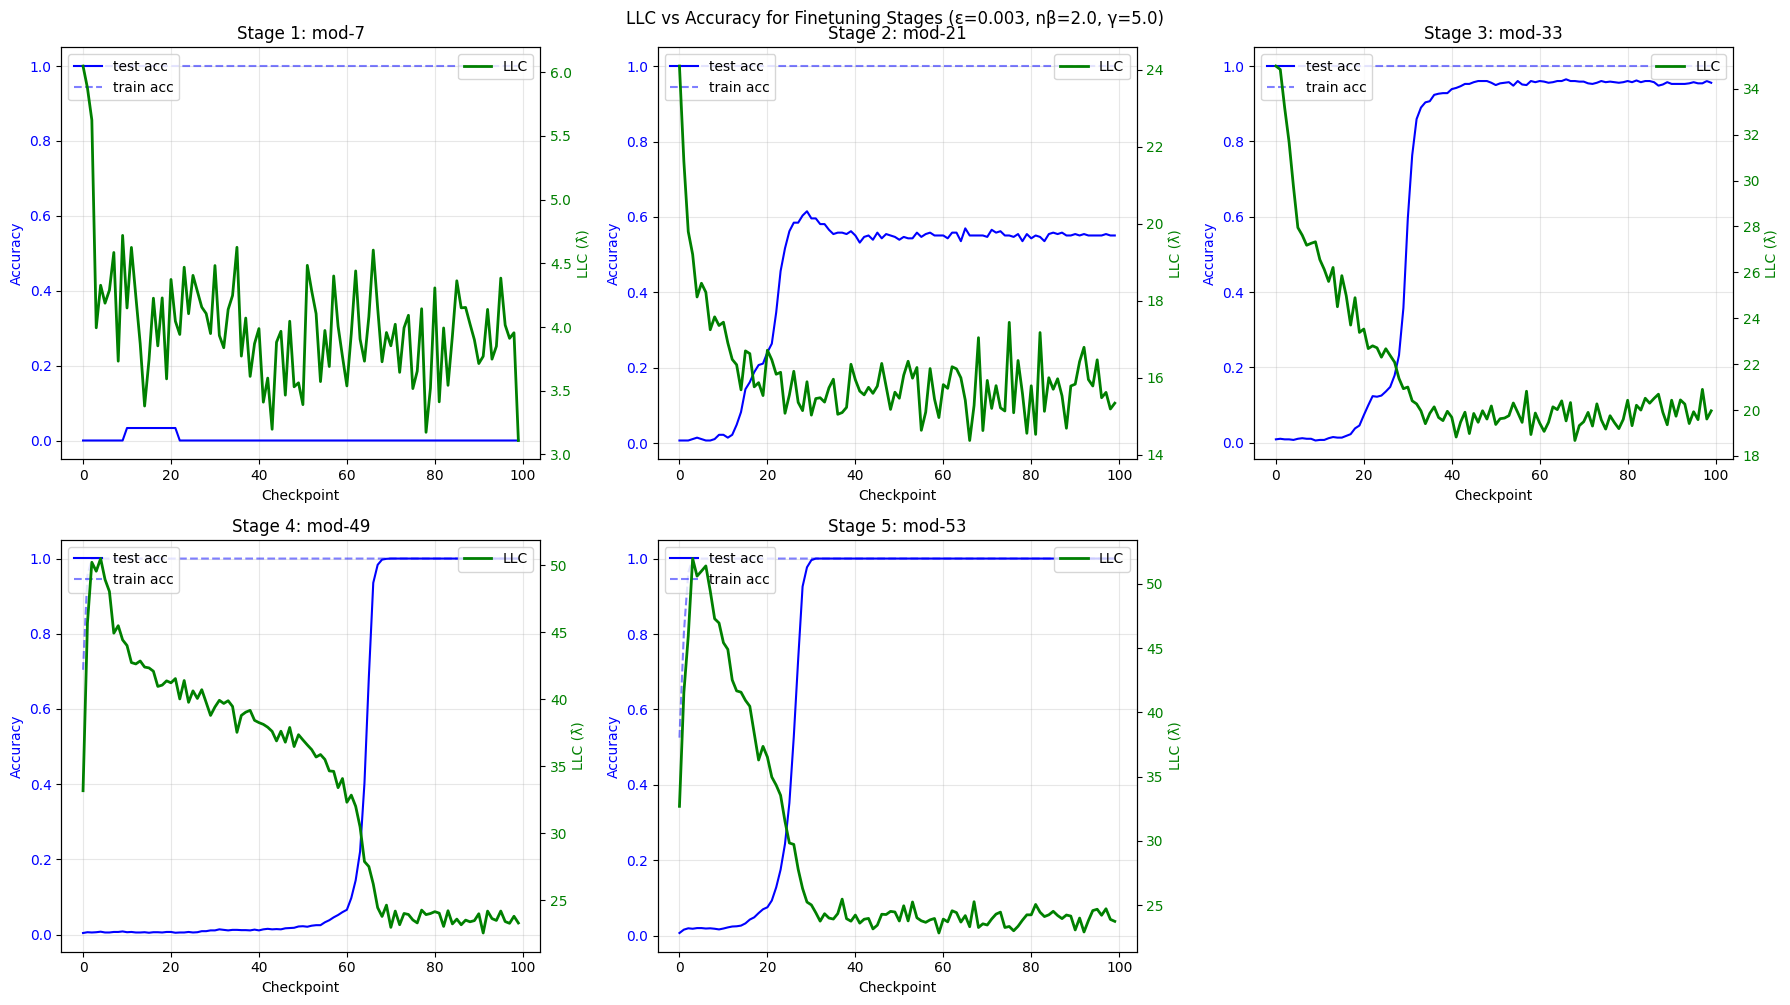

Saved: finetuning_llc_vs_accuracy.png


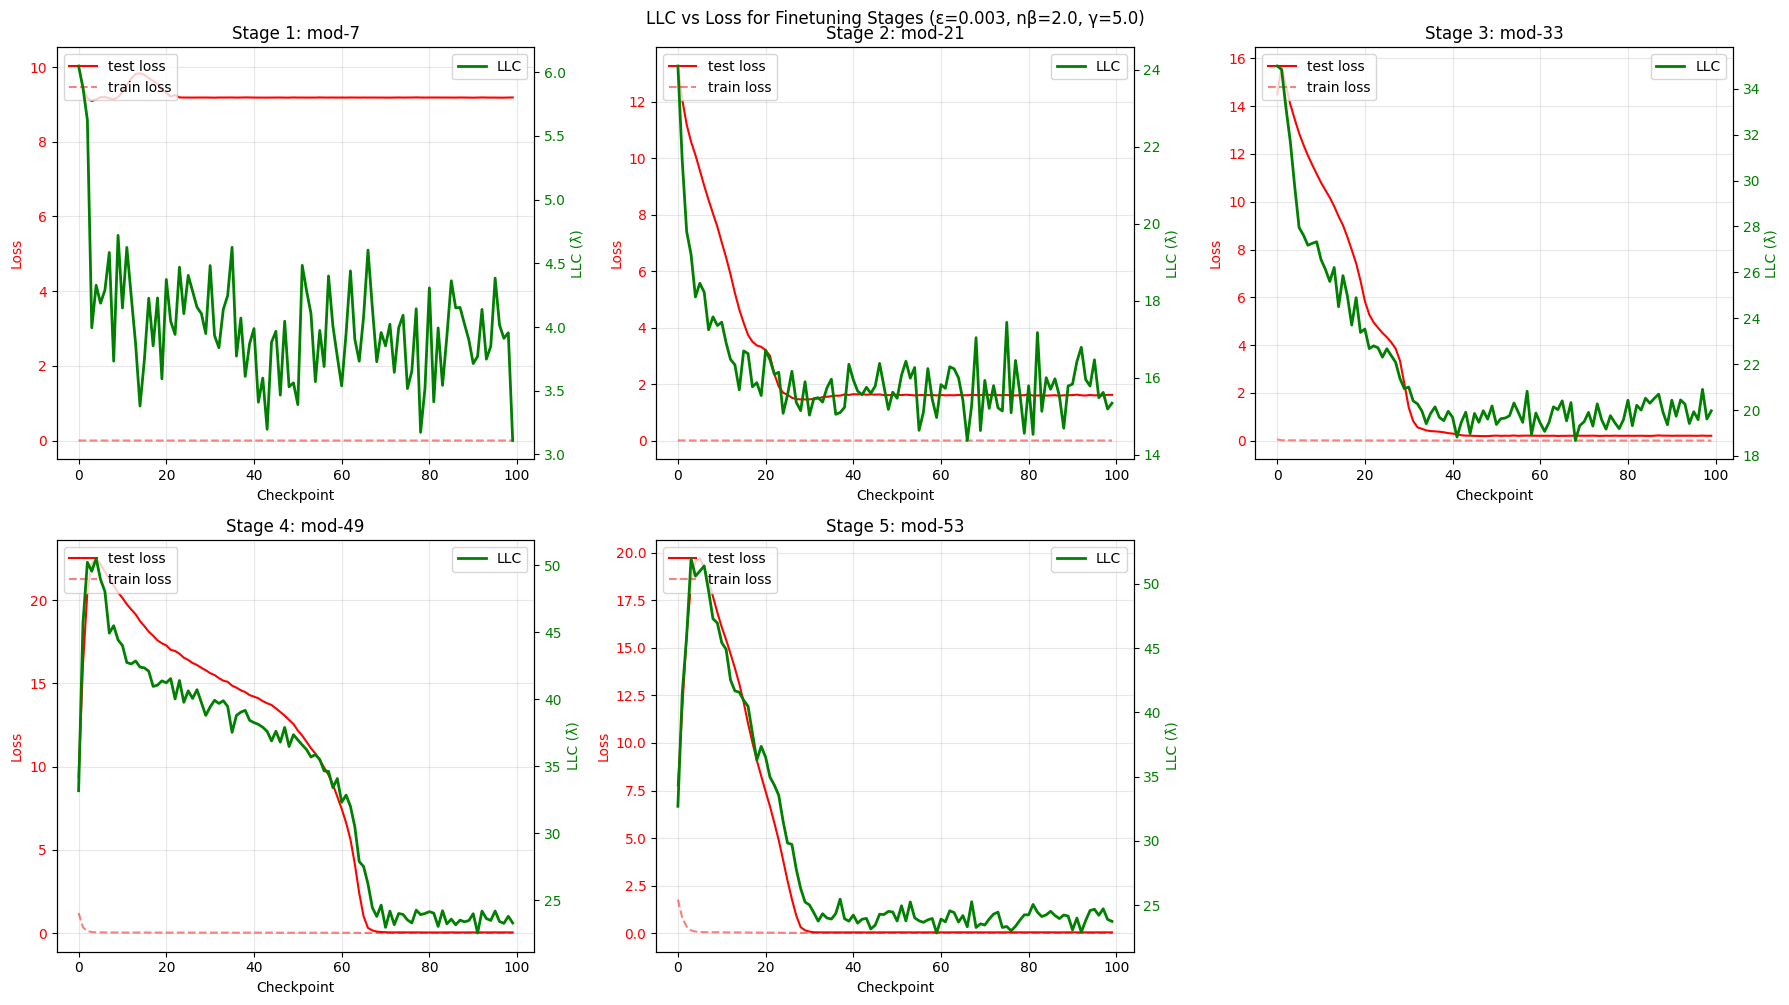

Saved: finetuning_llc_vs_loss.png


In [13]:
# Plot LLC trajectories for each finetuning stage (separate plots)
# Note: We have 5 stages, so create a 2x3 grid
fig, axes = plt.subplots(2, 3, figsize=(18, 10))
axes = axes.flatten()

for stage_idx, (stage_llcs, df, p) in enumerate(zip(finetuning_llcs_by_stage, finetuning_dfs, FINETUNING_MODULI)):
    ax1 = axes[stage_idx]
    ax2 = ax1.twinx()
    
    # Plot accuracy
    ax1.plot(df["val_acc"], label="test acc", color='blue')
    ax1.plot(df["train_acc"], label="train acc", color='blue', linestyle='--', alpha=0.5)
    
    # Plot LLC
    ax2.plot([llc["llc/mean"] for llc in stage_llcs], color='green', label="LLC", linewidth=2)
    
    ax1.set_xlabel("Checkpoint")
    ax1.set_ylabel("Accuracy", color='blue')
    ax2.set_ylabel("LLC (λ̂)", color='green')
    ax1.set_title(f"Stage {stage_idx+1}: mod-{p}")
    ax1.tick_params(axis='y', labelcolor='blue')
    ax2.tick_params(axis='y', labelcolor='green')
    ax1.legend(loc='upper left')
    ax2.legend(loc='upper right')
    ax1.grid(True, alpha=0.3)

# Hide the extra subplot
axes[-1].set_visible(False)

plt.tight_layout()
plt.suptitle(f"LLC vs Accuracy for Finetuning Stages (ε={lr}, nβ={nbeta}, γ={gamma})", y=1.00)
plt.show()
save_and_show(fig, "finetuning_llc_vs_accuracy.png")

# Plot LLC vs loss for each finetuning stage
fig, axes = plt.subplots(2, 3, figsize=(18, 10))
axes = axes.flatten()

for stage_idx, (stage_llcs, df, p) in enumerate(zip(finetuning_llcs_by_stage, finetuning_dfs, FINETUNING_MODULI)):
    ax1 = axes[stage_idx]
    ax2 = ax1.twinx()
    
    # Plot loss
    ax1.plot(df["val_loss"], label="test loss", color='red')
    ax1.plot(df["train_loss"], label="train loss", color='red', linestyle='--', alpha=0.5)
    
    # Plot LLC
    ax2.plot([llc["llc/mean"] for llc in stage_llcs], color='green', label="LLC", linewidth=2)
    
    ax1.set_xlabel("Checkpoint")
    ax1.set_ylabel("Loss", color='red')
    ax2.set_ylabel("LLC (λ̂)", color='green')
    ax1.set_title(f"Stage {stage_idx+1}: mod-{p}")
    ax1.tick_params(axis='y', labelcolor='red')
    ax2.tick_params(axis='y', labelcolor='green')
    ax1.legend(loc='upper left')
    ax2.legend(loc='upper right')
    ax1.grid(True, alpha=0.3)

# Hide the extra subplot
axes[-1].set_visible(False)

plt.tight_layout()
plt.suptitle(f"LLC vs Loss for Finetuning Stages (ε={lr}, nβ={nbeta}, γ={gamma})", y=1.00)
plt.show()
save_and_show(fig, "finetuning_llc_vs_loss.png")

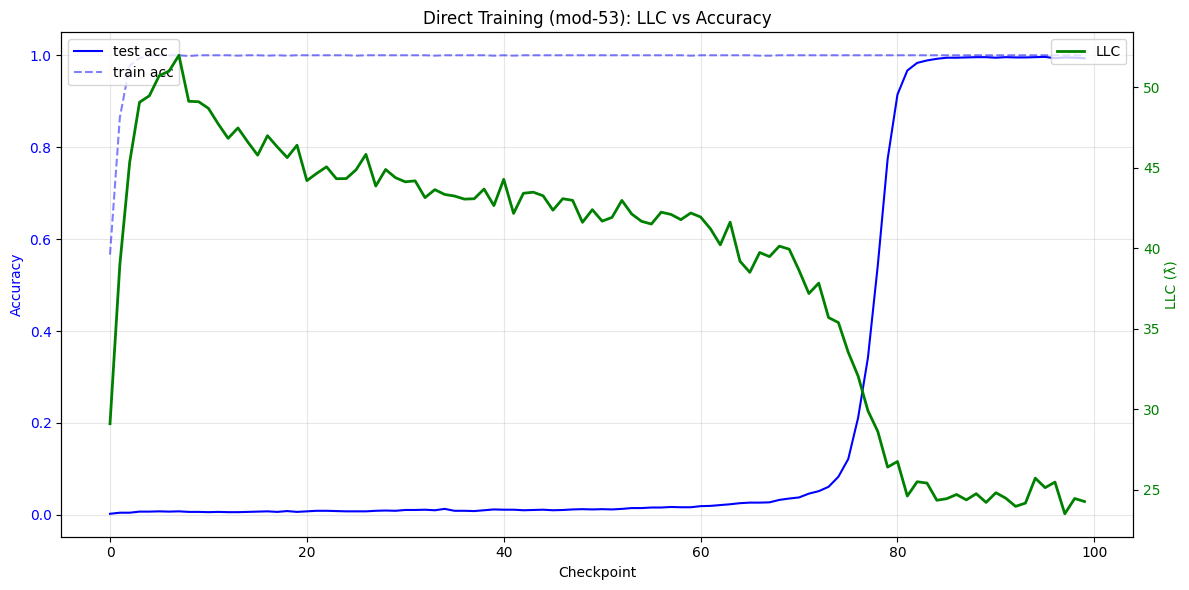

Saved: direct_llc_vs_accuracy.png


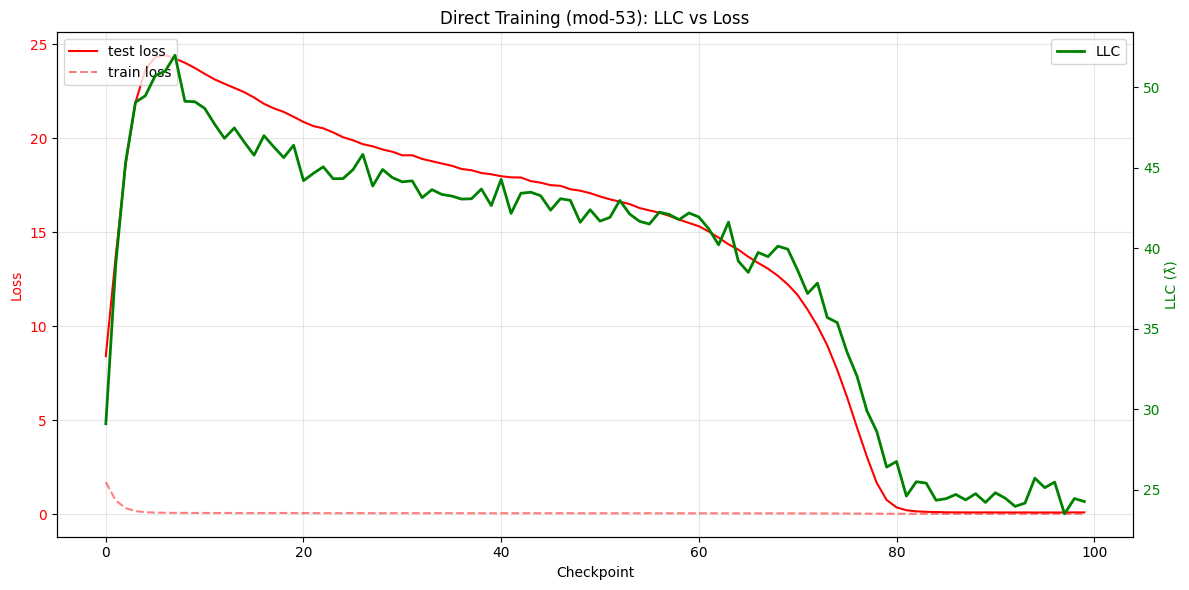

Saved: direct_llc_vs_loss.png


In [14]:
# Plot direct training: LLC vs Accuracy
fig, ax1 = plt.subplots(figsize=(12, 6))
ax2 = ax1.twinx()

ax1.plot(direct_df["val_acc"], label="test acc", color='blue')
ax1.plot(direct_df["train_acc"], label="train acc", color='blue', linestyle='--', alpha=0.5)
ax2.plot([llc["llc/mean"] for llc in direct_llcs], color='green', label="LLC", linewidth=2)

ax1.set_xlabel("Checkpoint")
ax1.set_ylabel("Accuracy", color='blue')
ax2.set_ylabel("LLC (λ̂)", color='green')
ax1.set_title(f"Direct Training (mod-{DIRECT_MODULUS}): LLC vs Accuracy")
ax1.tick_params(axis='y', labelcolor='blue')
ax2.tick_params(axis='y', labelcolor='green')
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')
ax1.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()
save_and_show(fig, "direct_llc_vs_accuracy.png")

# Plot direct training: LLC vs Loss
fig, ax1 = plt.subplots(figsize=(12, 6))
ax2 = ax1.twinx()

ax1.plot(direct_df["val_loss"], label="test loss", color='red')
ax1.plot(direct_df["train_loss"], label="train loss", color='red', linestyle='--', alpha=0.5)
ax2.plot([llc["llc/mean"] for llc in direct_llcs], color='green', label="LLC", linewidth=2)

ax1.set_xlabel("Checkpoint")
ax1.set_ylabel("Loss", color='red')
ax2.set_ylabel("LLC (λ̂)", color='green')
ax1.set_title(f"Direct Training (mod-{DIRECT_MODULUS}): LLC vs Loss")
ax1.tick_params(axis='y', labelcolor='red')
ax2.tick_params(axis='y', labelcolor='green')
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')
ax1.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()
save_and_show(fig, "direct_llc_vs_loss.png")

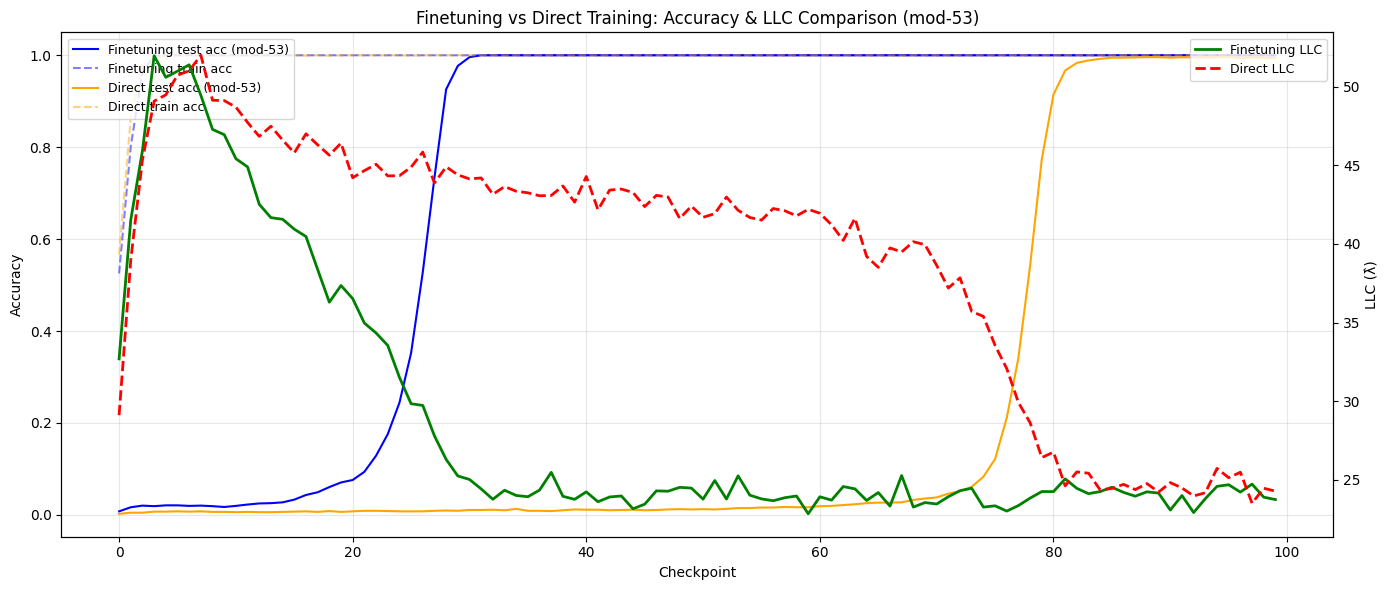

Saved: finetuning_vs_direct_accuracy_llc_comparison.png


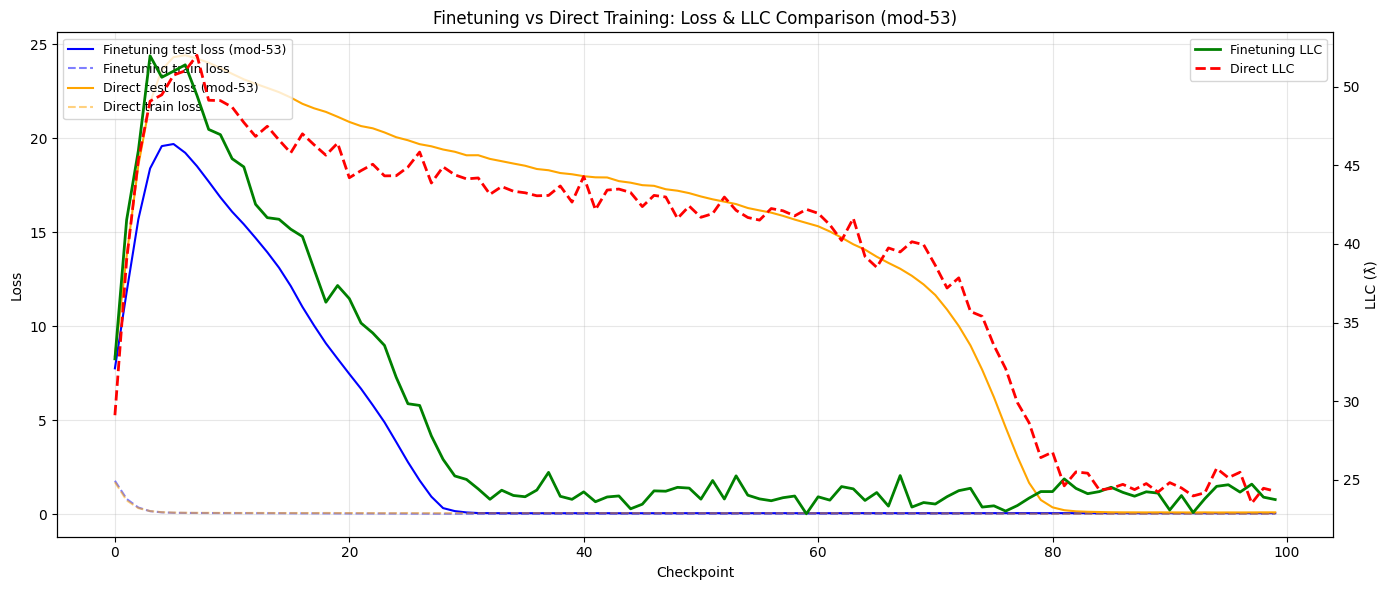

Saved: finetuning_vs_direct_loss_llc_comparison.png


In [15]:
# Comparison: Finetuning final stage vs Direct training (LLC vs Accuracy)
fig, ax1 = plt.subplots(figsize=(14, 6))
ax2 = ax1.twinx()

# Finetuning final stage
finetuning_final_llcs = finetuning_llcs_by_stage[-1]
finetuning_final_df = finetuning_dfs[-1]

ax1.plot(finetuning_final_df["val_acc"], label=f"Finetuning test acc (mod-{FINETUNING_MODULI[-1]})", color='blue')
ax1.plot(finetuning_final_df["train_acc"], label=f"Finetuning train acc", color='blue', linestyle='--', alpha=0.5)

# Direct training
ax1.plot(direct_df["val_acc"], label=f"Direct test acc (mod-{DIRECT_MODULUS})", color='orange')
ax1.plot(direct_df["train_acc"], label=f"Direct train acc", color='orange', linestyle='--', alpha=0.5)

# LLC overlay
ax2.plot([llc["llc/mean"] for llc in finetuning_final_llcs], color='green', label="Finetuning LLC", linewidth=2)
ax2.plot([llc["llc/mean"] for llc in direct_llcs], color='red', label="Direct LLC", linewidth=2, linestyle='--')

ax1.set_xlabel("Checkpoint")
ax1.set_ylabel("Accuracy")
ax2.set_ylabel("LLC (λ̂)")
ax1.set_title(f"Finetuning vs Direct Training: Accuracy & LLC Comparison (mod-{DIRECT_MODULUS})")
ax1.legend(loc='upper left', fontsize=9)
ax2.legend(loc='upper right', fontsize=9)
ax1.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()
save_and_show(fig, "finetuning_vs_direct_accuracy_llc_comparison.png")

# Comparison: Finetuning final stage vs Direct training (LLC vs Loss)  
fig, ax1 = plt.subplots(figsize=(14, 6))
ax2 = ax1.twinx()

# Loss curves
ax1.plot(finetuning_final_df["val_loss"], label=f"Finetuning test loss (mod-{FINETUNING_MODULI[-1]})", color='blue')
ax1.plot(finetuning_final_df["train_loss"], label=f"Finetuning train loss", color='blue', linestyle='--', alpha=0.5)
ax1.plot(direct_df["val_loss"], label=f"Direct test loss (mod-{DIRECT_MODULUS})", color='orange')
ax1.plot(direct_df["train_loss"], label=f"Direct train loss", color='orange', linestyle='--', alpha=0.5)

# LLC overlay
ax2.plot([llc["llc/mean"] for llc in finetuning_final_llcs], color='green', label="Finetuning LLC", linewidth=2)
ax2.plot([llc["llc/mean"] for llc in direct_llcs], color='red', label="Direct LLC", linewidth=2, linestyle='--')

ax1.set_xlabel("Checkpoint")
ax1.set_ylabel("Loss")
ax2.set_ylabel("LLC (λ̂)")
ax1.set_title(f"Finetuning vs Direct Training: Loss & LLC Comparison (mod-{DIRECT_MODULUS})")
ax1.legend(loc='upper left', fontsize=9)
ax2.legend(loc='upper right', fontsize=9)
ax1.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()
save_and_show(fig, "finetuning_vs_direct_loss_llc_comparison.png")

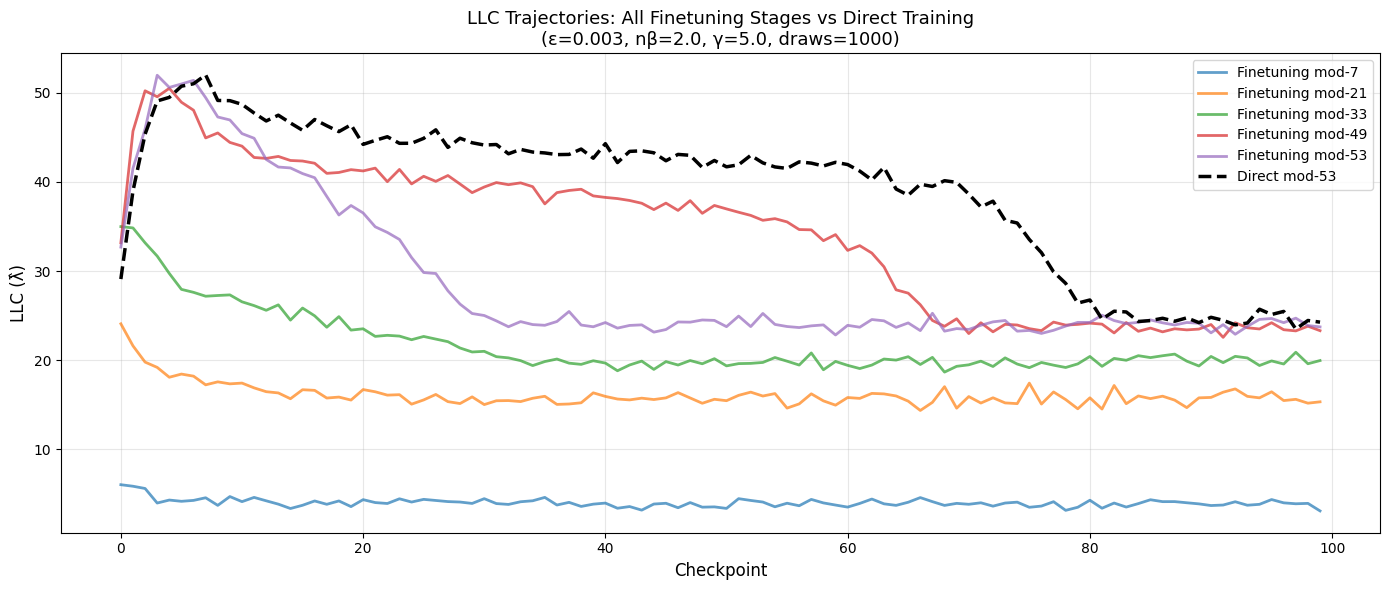

Saved: llc_trajectories_comparison.png

SUMMARY: LLC Statistics

Finetuning Stage 1 (mod-7):
  Initial LLC: 6.05
  Final LLC:   3.11
  Min LLC:     3.11
  Max LLC:     6.05

Finetuning Stage 2 (mod-21):
  Initial LLC: 24.09
  Final LLC:   15.34
  Min LLC:     14.37
  Max LLC:     24.09

Finetuning Stage 3 (mod-33):
  Initial LLC: 34.99
  Final LLC:   19.97
  Min LLC:     18.68
  Max LLC:     34.99

Finetuning Stage 4 (mod-49):
  Initial LLC: 33.18
  Final LLC:   23.32
  Min LLC:     22.57
  Max LLC:     50.50

Finetuning Stage 5 (mod-53):
  Initial LLC: 32.69
  Final LLC:   23.74
  Min LLC:     22.84
  Max LLC:     51.96

Direct Training (mod-53):
  Initial LLC: 29.11
  Final LLC:   24.28
  Min LLC:     23.51
  Max LLC:     52.00


In [16]:
# Plot LLC trajectories only (for clearer comparison)
fig = plt.figure(figsize=(14, 6))

# Plot each finetuning stage
for stage_idx, (stage_llcs, p) in enumerate(zip(finetuning_llcs_by_stage, FINETUNING_MODULI)):
    plt.plot([llc["llc/mean"] for llc in stage_llcs], 
             label=f"Finetuning mod-{p}", 
             linewidth=2,
             alpha=0.7)

# Plot direct training
plt.plot([llc["llc/mean"] for llc in direct_llcs], 
         label=f"Direct mod-{DIRECT_MODULUS}", 
         linewidth=2.5,
         linestyle='--',
         color='black')

plt.xlabel("Checkpoint", fontsize=12)
plt.ylabel("LLC (λ̂)", fontsize=12)
plt.title(f"LLC Trajectories: All Finetuning Stages vs Direct Training\n(ε={lr}, nβ={nbeta}, γ={gamma}, draws={num_draws})", fontsize=13)
plt.legend(fontsize=10)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()
save_and_show(fig, "llc_trajectories_comparison.png")

# Summary statistics
print("\n" + "="*80)
print("SUMMARY: LLC Statistics")
print("="*80)
for stage_idx, (stage_llcs, p) in enumerate(zip(finetuning_llcs_by_stage, FINETUNING_MODULI)):
    llc_values = [llc["llc/mean"] for llc in stage_llcs]
    print(f"\nFinetuning Stage {stage_idx+1} (mod-{p}):")
    print(f"  Initial LLC: {llc_values[0]:.2f}")
    print(f"  Final LLC:   {llc_values[-1]:.2f}")
    print(f"  Min LLC:     {min(llc_values):.2f}")
    print(f"  Max LLC:     {max(llc_values):.2f}")

direct_llc_values = [llc["llc/mean"] for llc in direct_llcs]
print(f"\nDirect Training (mod-{DIRECT_MODULUS}):")
print(f"  Initial LLC: {direct_llc_values[0]:.2f}")
print(f"  Final LLC:   {direct_llc_values[-1]:.2f}")
print(f"  Min LLC:     {min(direct_llc_values):.2f}")
print(f"  Max LLC:     {max(direct_llc_values):.2f}")
print("="*80)